In [1]:
# -*- coding: utf-8 -*-

import matplotlib.pyplot as plt
import numpy as np
import os
import librosa
import scipy.fftpack
import scipy.interpolate

import time

In [2]:
import types
def print_varsize():
    #ファイル容量とか
    print("{}{: >15}{}{: >10}{}".format('|','Variable Name','|','  Size','|'))
    print(" -------------------------- ")
    for k, v in globals().items():
        if hasattr(v, 'size') and not k.startswith('_') and not isinstance(v,types.ModuleType):
            print("{}{: >15}{}{: >10}{}".format('|',k,'|',str(v.size),'|'))
        elif hasattr(v, '__len__') and not k.startswith('_') and not isinstance(v,types.ModuleType):
            print("{}{: >15}{}{: >10}{}".format('|',k,'|',str(len(v)),'|'))

In [3]:
def loadWavefile(filename,rate=44100,mono=True):
    #wavファイル読み込み
    if not os.path.exists(filename):
        print('wav data is nothing')
        print('o・∇・o')
    y,sr = librosa.load(filename,sr=rate,mono=mono)
    return y,sr

def outputWavefile(filepath,y,rate=44100,overwrite=False):
    #wavファイル出力
    if overwrite:
        os.remove(filepath)
        librosa.output.write_wav(filepath,y,rate)
    elif os.path.exists(filepath):
        print('wav data is already there')
        print('o・∇・o')
    else:
        librosa.output.write_wav(filepath,y,rate)

In [4]:
def preEmphasis(wave,a=0.97):
    #Pre-Emphasis filter
    emphasized_wave = np.append(wave[0], wave[1:] - a * wave[:-1])
    return emphasized_wave

In [5]:
def hammingWindow(wave,alpha=0.54):
    #Hamming window
    nmax = len(wave)
    n = np.linspace(0,nmax-1,nmax)
    wx = alpha-((1-alpha)*np.cos(2.0*np.pi*n/nmax))
    hamming_wave = wx * wave
    return hamming_wave

def hammingWindow_matrix(wave_matrix,alpha=0.54):
    #Hamming window for matrix
    nmax = len(wave_matrix[0])
    n = np.linspace(0,nmax-1,nmax)
    wx = alpha-((1-alpha)*np.cos(2.0*np.pi*n/nmax))
    hamming_wave_matrix = wave_matrix * wx
    return hamming_wave_matrix

In [6]:
def framing(wave,frame_size=1024,no_voice_cut=False,threshold=0):
    #frame distribution device
    frame_stride = int(frame_size/2)
    wavedata_length = len(wave)
    frame_number = int(wavedata_length/frame_stride) - 1
    s_list = [frame_stride*n for n in range(frame_number)]
    e_list = [frame_stride*n+frame_size for n in range(frame_number)]
    
    wave_framing = np.empty((frame_number,frame_size))
    no_soundless = []
    for i,(s,e) in enumerate(zip(s_list,e_list)):
        wave_frame = wave[s:e]
        wave_framing[i] = wave_frame
        if no_voice_cut:
            if np.max(np.abs(wave_frame)) > threshold:
                no_soundless.append(i)
    #無音(微音)部分のカット            
    if no_voice_cut:
        wave_framing = wave_framing[no_soundless]
        
    return wave_framing

In [7]:
def clear_framing(frame,frame_size=1024):
    #フレームに分割していたデータの統合
    frame_number = len(frame)
    frame_stride = int(frame_size/2)
    s_list = [frame_stride*n for n in range(frame_number)]
    e_list = [frame_stride*n+frame_size for n in range(frame_number)]
    no_frame = np.empty(frame_size+(frame_stride*(frame_number-1)))
    for i,(s,e) in enumerate(zip(s_list,e_list)):
        no_frame[s:e] += frame[i]
    return no_frame.astype(np.float32)

In [8]:
def hz2mel(Hz):
    #Hz to mel
    mel = 1127.01048 * np.log(Hz / 700.0 + 1.0)
    return mel

def mel2hz(mel):
    #mel to Hz
    Hz = 700.0 * (np.exp(mel / 1127.01048) - 1.0)
    return Hz

In [9]:
def melFilterBank(fs, nfft, numChannels, index_only=False):
    #メルフィルタバンクを作成
    # ナイキスト周波数
    fmax = fs / 2
    melmax = hz2mel(fmax)
    # 周波数インデックスの最大数
    nmax = int(nfft / 2)
    # 周波数分解能
    df = fs / nfft
    # 各フィルタの中心周波数(mel)
    dmel = melmax / (numChannels + 1)
    melcenters = np.arange(1, numChannels + 1) * dmel
    # 各フィルタの中心周波数をHzに変換
    fcenters = mel2hz(melcenters)
    # 各フィルタの周波数を周波数インデックスに変換
    indexcenter = np.round(fcenters / df)
    indexstart = np.hstack(([0], indexcenter[0:numChannels - 1]))
    indexstop = np.hstack((indexcenter[1:numChannels], [nmax]))
    
    indexcenter = np.array(indexcenter,dtype='int32')
    indexstart = np.array(indexstart,dtype='int32')
    indexstop = np.array(indexstop,dtype='int32')

    if index_only:
        return melcenters,melmax
    
    filterbank = np.zeros((numChannels, nmax))
    for c in np.arange(0, numChannels):
        increment= 1.0 / (indexcenter[c] - indexstart[c])
        for i in np.arange(indexstart[c], indexcenter[c]):
            filterbank[c, i] = (i - indexstart[c]) * increment
        decrement = 1.0 / (indexstop[c] - indexcenter[c])
        for i in np.arange(indexcenter[c], indexstop[c]):
            filterbank[c, i] = 1.0 - ((i - indexcenter[c]) * decrement)

    return filterbank, fcenters

In [17]:
def calcMFCC(wave,sr,no_voice_cut=True,frame_size=1024,numChannels=20,dimension=16):
    
    #waveデータを分割
    wave_frame = framing(wave,no_voice_cut=no_voice_cut,threshold=0.005)
    #ハミング窓
    wave_hw = hammingWindow_matrix(wave_frame)
    del wave_frame
    #FFT
    wave_fft = np.fft.fft(wave_hw)
    del wave_hw
    NFFT = int(frame_size)
    wave_fft_scale = np.fft.fftfreq(NFFT,d=1.0)[:NFFT//2]
    wave_fft_amp = np.abs(wave_fft[:,:NFFT//2])
    
    #メルフィルタバンク
    filterbank, fcenters = melFilterBank(sr, NFFT, numChannels)    
    mspectrum = np.log10(np.dot(wave_fft_amp, filterbank.T))
    mfcc = scipy.fftpack.dct(mspectrum, norm = 'ortho')
    
    return mfcc,fcenters

In [11]:
def iMFCC(mfcc,fcenters,NFFT=1024,fs=44100):
    #MFCCからスペクトラム包絡の逆算
    mspectrum = scipy.fftpack.idct(mfcc, norm = 'ortho')
    spectrum = np.empty((len(mfcc),NFFT//2))
    for i in range(len(mfcc)):
        tck = scipy.interpolate.splrep(fcenters, np.power(10, mspectrum[i]))
        fscale = np.fft.fftfreq(NFFT, d = 1.0 / fs)[:NFFT//2]
        spectrum[i] = scipy.interpolate.splev(fscale, tck)
        spectrum[i] = np.maximum(np.zeros(spectrum[i].shape),spectrum[i])
        spectrum[i][np.isnan(spectrum[i])] = 0
    return spectrum

In [12]:
def makeMFCCFilter(mfcc_factor, sr=44100, NFFT=1024):
    numChannels = len(mfcc_factor)
    center, melmax = melFilterBank(44100, nfft=NFFT, numChannels=numChannels, index_only=True)
    df = int(melmax/(numChannels+1))
    mel_factor = np.zeros(int(melmax+2*df))
    sigma = int(df/1.6)
    for i,center_section in enumerate(center):
        line = np.linspace(0,df*4-1,df*4)
        gaussian = (1/1.561178)*mfcc_factor[i]*np.exp(-1*((line-df*2)**2)/(2*sigma**2))
        mel_factor[df*(i):df*(i+4)] += gaussian
    mel_factor = mel_factor[df:]

    gaussian_hz = np.empty(NFFT//2)
    for i in range(NFFT//2):
        hz = 1.0*sr/NFFT*i
        mel = int(hz2mel(hz))
        gaussian_hz[i] = mel_factor[mel]

    gaussian_hz_2 = gaussian_hz[1:]
    gaussian_hz = np.hstack((gaussian_hz, np.array([1]), gaussian_hz_2[::-1]))
    
    return gaussian_hz

In [119]:
def change_voice(wave,sr,no_voice_cut=False,frame_size=1024,numChannels=20):
    #calcMFCCと重複、あとでなんとかする
    
    #waveデータを分割
    wave_frame = framing(wave,no_voice_cut=no_voice_cut,threshold=0.005)
    #ハミング窓
    wave_hw = hammingWindow_matrix(wave_frame) 
    del wave_frame
    #FFT
    wave_fft = np.fft.fft(wave_hw)
    del wave_hw
    NFFT = frame_size
    #wave_fft_scale = np.fft.fftfreq(NFFT,d=1.0)[:NFFT/2]
    wave_fft_amp = np.abs(wave_fft[:,:NFFT//2])
    
    plt.plot(wave_fft_amp[3])
    plt.show()
    
    #メルフィルタバンク
    filterbank, fcenters = melFilterBank(sr, NFFT, numChannels)    
    mspectrum = np.log10(np.dot(wave_fft_amp, filterbank.T))
    mfcc = scipy.fftpack.dct(mspectrum, norm = 'ortho')
    
    #変声
    mfcc_changer = mfcc
    
    #IFFT
    spectrum = iMFCC(mfcc_changer,fcenters)
    spectrum_rebirth = np.fliplr(spectrum)
    spectrum_rebirth = np.delete(spectrum_rebirth,-1,1)
    spectrum = np.hstack((spectrum,np.zeros((len(spectrum),1)),spectrum_rebirth))
    
    plt.plot(spectrum[3,:NFFT//2])
    plt.show()
    
    wave_ifft = np.fft.ifft(spectrum)
    wave_ifft = wave_ifft.real
    wave_after = clear_framing(wave_ifft)
    
    return wave_after

In [128]:
#data = np.linspace(0,10000,44100*120)
#data = np.cos(data*15)+np.sin(data*22)

data,sr = loadWavefile("../data/LearningData/magiarecord/1/1080.wav")
#data,sr = np.loadtxt("1080.csv",delimiter=","),44100

#data,sr = loadWavefile("../data/LearningData/magiarecord/1/3.wav")
print(len(data))
print(data)

218250
[ 0.  0.  0. ...,  0.  0.  0.]


In [126]:
mfcc,fcenters = calcMFCC(data,sr,no_voice_cut=True,numChannels=64)
print(len(mfcc))

2297


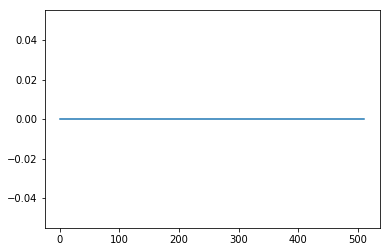

C:\Users\sho\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
C:\Users\sho\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in maximum
  if __name__ == '__main__':


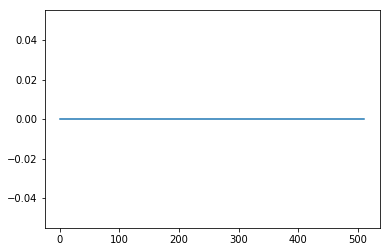

In [132]:
wave_after = change_voice(data,sr,no_voice_cut=False,numChannels=64)
outputWavefile("../data/mocho.wav",wave_after,overwrite=True)

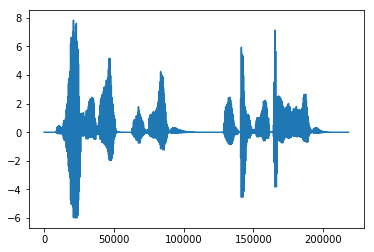

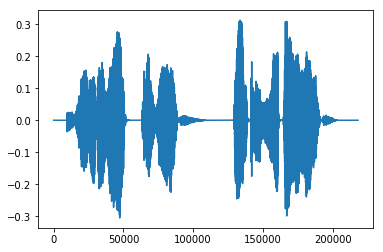

In [137]:
plt.plot(wave_after)
#plt.xlim(160000,161000)
plt.show()
plt.plot(data)
#plt.xlim(160000,161000)
plt.show()